In [ ]:
"Créditos: Las funciones acá empleadas fueron modificadas de Torres Quintero et al.(2024), Repositorio GitHub: ."

In [1]:
import numpy as np
import cv2
import scipy as sc
import skimage as ski
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
torch.pi = torch.Tensor([math.pi])

In [2]:
Fuente = 'D:/TESIS/Fase3/sismicatest.npy'
Fuentef = 'D:/TESIS/Fase3/mascarastest.npy'


In [3]:
sismica = np.load(Fuente, mmap_mode='r')
fallas = np.load(Fuentef, mmap_mode='r')
#sismica = torch.from_numpy(np.array(sismica))

FileNotFoundError: [Errno 2] No such file or directory: 'D:/TESIS/Fase3/sismicatest.npy'

In [5]:
#import os


# Carpeta donde guardar los archivos
#output_folder = "D:/TESIS/Fase3/MáscarasTest"
#os.makedirs(output_folder, exist_ok=True)

# Guardar cada submatriz
#for i in range(fallas.shape[0]):
    #filename = os.path.join(output_folder, f"Test_{i+1}.npy")
   # np.save(filename, fallas[i])


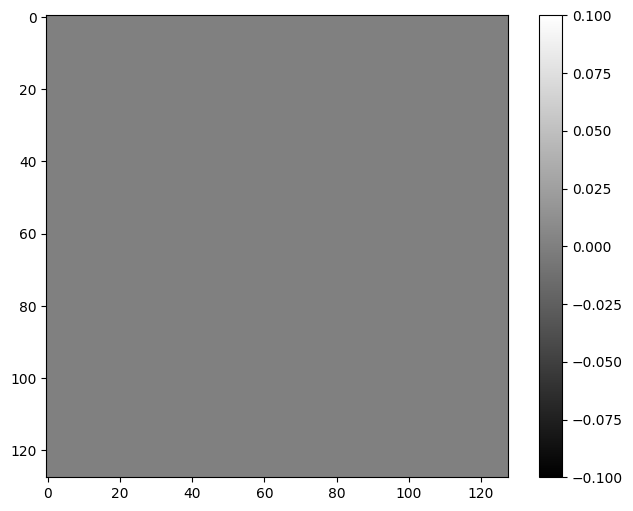

In [5]:
plt.figure(figsize=[8,6])
plt.imshow(sismica[9,:,:].T, interpolation='nearest', cmap='gist_gray')
#plt.imshow(fallas.T, interpolation='nearest', cmap='Reds', alpha=0.2)
plt.colorbar()

In [20]:

class degradeImage:
    def __init__(self, img):
        '''
        :param img: The 'img' parameter refers to the image to modify
        '''
        self.original = img
        self.img = img

        # Convertir a numpy si es tensor
        if isinstance(self.img, torch.Tensor):
            self.img = self.img.numpy()

        # Normalizar y reconvertir a tensor
        self.img = self.img.astype(dtype=np.float32)
        self.img = torch.from_numpy(self.img)

    def impulseNoise(self, AMOUNT):
        '''
        Adds impulse noise (salt and pepper) to the image.
        '''
        SALT_VS_PEPPER = 0.5

        # Crear una copia del tensor original
        noisy_image_SP_tensor = self.img.clone()

        # Número de píxeles afectados por el ruido
        number_faulty_pixels = int(np.ceil(AMOUNT * self.img.numel()))

        # Índices aleatorios
        indices = torch.randint(0, self.img.shape[0], (2, number_faulty_pixels))

        # Valores aleatorios para ruido de sal y pimienta
        values = torch.tensor(
            np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels),
            dtype=torch.float32
        )

        # Asignar los valores de ruido
        noisy_image_SP_tensor[indices[0], indices[1]] = values

        # Normalizar el resultado
        im_img = noisy_image_SP_tensor
        im_img -= im_img.min()
        im_img /= im_img.max()

        return im_img
    
    def gaussianNoise(self,sigma, intensity):
        '''
        A matrix of zeros with the dimensions of image is generated.
        to make sure there are no issues, the 'dtype' is specified to be the same as image
        The zero matrix is now refilled with randomly generated values that follow the Gaussian distribution
        using the 'sigma' value to create the noise, Finally, the noise is added to image
        :param sigma: The 'sigma' parameter refers to the standard deviation used to generate the noise
        :return: it is returned the image with gaussian noise
        '''
        gauss_noise = torch.empty(self.img.shape).normal_(mean=0,std=sigma)
        gauss_noise -= gauss_noise.min()
        gauss_noise /= gauss_noise.max()
        #gauss_noise=torch.randn_like(self.img)
        gn_img = self.img + gauss_noise * intensity
        gn_img -= gn_img.min()
        gn_img /= gn_img.max()
        '''
        gauss_noise=np.zeros(self.img.shape,dtype=self.img.dtype)
        cv2.randn(gauss_noise,0,sigma)
        gauss_noise = (gauss_noise).astype(self.img.dtype)
        gauss_noise -= gauss_noise.min()
        gauss_noise /= gauss_noise.max()

        gn_img = self.img + gauss_noise
        gn_img -= gn_img.min()
        gn_img /= gn_img.max()
        '''
        return gn_img
    
    def streak(self, amount):
        num = torch.randint(1, 128, (1,1)).item()

        streak_img = self.img
        vec = []

        for j in range(streak_img.shape[0]):
            vec.append(streak_img[num][j])

        unique_positions = np.random.choice(128, size=amount, replace=False)

        for pos in unique_positions:
            for m in range(streak_img.shape[0]):
                streak_img[pos][m] = vec[m]
            self.img -= self.img.min()
            self.img /= self.img.max()
        return streak_img

    def waves(self, intensity, overlap1, overlap2):

        waves_img = self.img

        hor, verti = waves_img.shape[0], waves_img.shape[1]
        a = torch.zeros(self.img.shape);

        x1 = torch.linspace(-verti // 2, verti // 2, verti)
        x2 = torch.linspace(-hor // 2, hor // 2, hor)
        [X, Y] = torch.meshgrid(x2, x1)

        r2 = torch.empty(1).uniform_(0.4, 0.7).item()
        r3 = torch.empty(1).uniform_(0.1, 0.7).item()
        r4 = torch.empty(1).uniform_(0.1, 0.7).item()

        for i, y in enumerate(x2, start=0):
            r = np.random.uniform(1, 1.1)
            for j, x in enumerate(x1, start=0):
                a[j, i] = torch.sin(y + (r * x ** 2))
        b = torch.sin(Y + (r2 * X ** 2))
        c = torch.sin(Y + (r3 * X ** 2))
        d = torch.sin(Y + (r4 * X ** 2))

        a -= a.min(); a /= a.max(); b -= b.min(); b /= b.max()
        c -= c.min(); c /= c.max(); d -= d.min(); d /= d.max()


        it = 1 #torch.randint(0,3,(1,1)).item()

        ra = torch.randint(overlap1, overlap2, (1,1)).item()
        ra1 = torch.randint(overlap1, overlap2, (1,1)).item()

        if it == 0:
            waves_img = waves_img + a * intensity * waves_img
        elif it == 1:
            waves_img = waves_img + b * intensity * waves_img
        else:
            z = b
            f = c
            s = d
            z[0:ra, 0:128] = f[0:ra, 0:128] + z[0:ra, 0:128]
            z[ra1:128, 0:128] = s[ra1:128, 0:128] + z[ra1:128, 0:128]
            z -= z.min()
            z /= z.max()
            waves_img = waves_img + z * intensity * waves_img

        waves_img -= waves_img.min()
        waves_img /= waves_img.max()

        return waves_img
    
    
    

 

#            overlap1 = np.random.randint(1, 40)
 #           overlap2 = np.random.randint(40,70)
  #          intensity = np.random.uniform(0.15, 0.35)
   #


In [9]:
imagen_tensor.shape

torch.Size([128, 128])

In [28]:
import os

overlap1 = np.random.randint(1, 40)
overlap2 = np.random.randint(40,70)
intensity = 1
sigma = np.random.random()
#intensity = 1
# Carpeta donde guardar los archivos
output_folder = "D:/TESIS/Fase3/Impulsive_Noise/Test_100"
os.makedirs(output_folder, exist_ok=True)

# Guardar cada submatriz
for i in range(sismica.shape[0]):
    filename = os.path.join(output_folder, f"Test_{i+1}.npy")
    imagen_tensor = torch.from_numpy(sismica[i,:,:]).float()
    dm_img = degradeImage(imagen_tensor).impulseNoise(AMOUNT=intensity) #waves(intensity, overlap1, overlap2)
    np.save(filename,dm_img)




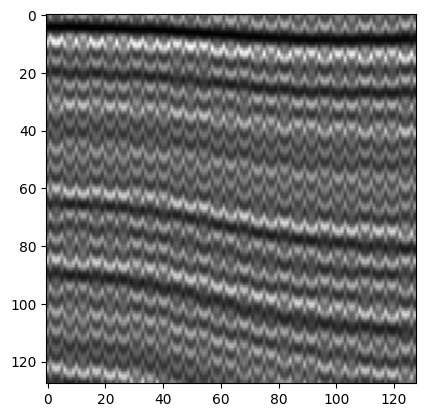

In [12]:

overlap1 =  np.random.randint(1, 40)
overlap2 =  np.random.randint(40,70)
intensity = 1
imagen_tensor = torch.from_numpy(sismica[12,:,:]).float()
dm_img = degradeImage(imagen_tensor).waves(intensity, overlap1, overlap2)
plt.imshow(dm_img.T, cmap= 'gray')

In [25]:
prueba = "D:/TESIS/Fase3/Test_0/Test_17.npy"
prueba1 = "D:/TESIS/Fase3/Swell_Noise/Test_25/Test_17.npy"
prueba2 = "D:/TESIS/Fase3/Swell_Noise/Test_50/Test_17.npy"
prueba3 = "D:/TESIS/Fase3/Swell_Noise/Test_75/Test_17.npy"
prueba4 = "D:/TESIS/Fase3/Swell_Noise/Test_100/Test_17.npy"
prueba = np.load(prueba, mmap_mode='r')
prueba1 = np.load(prueba1, mmap_mode='r')
prueba2= np.load(prueba2, mmap_mode='r')
prueba3= np.load(prueba3, mmap_mode='r')
prueba4= np.load(prueba4, mmap_mode='r')



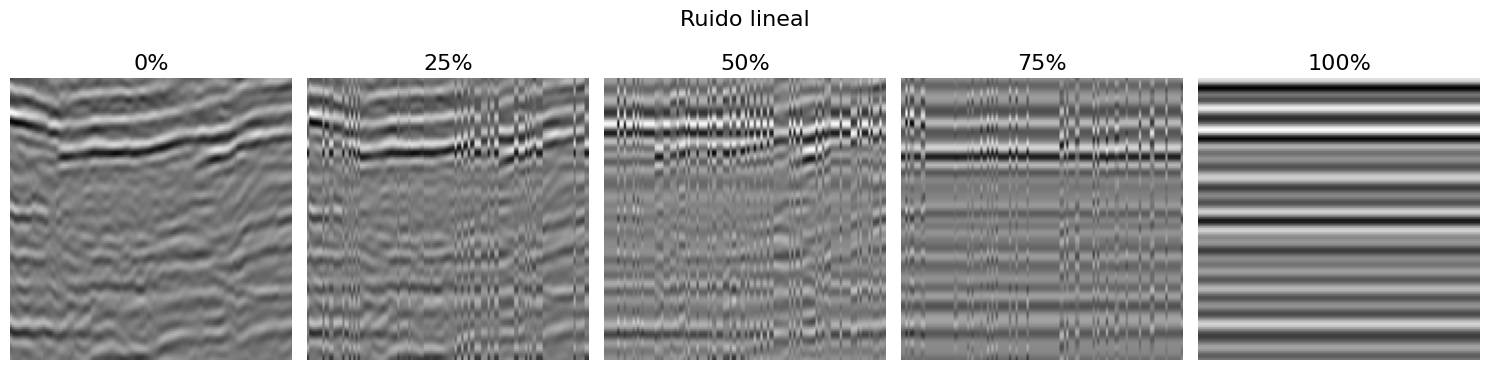

In [26]:
save_path = "D:/TESIS/Imagenes/streak_image.svg"

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))

ax1.imshow(prueba.T, cmap='gray')
ax1.axis('off')
ax1.set_title("0%",fontsize=16)

ax2.imshow(prueba1.T, cmap='gray')
ax2.axis('off')
ax2.set_title("25%",fontsize=16)

ax3.imshow(prueba2.T, cmap='gray')
ax3.axis('off')
ax3.set_title("50%",fontsize=16)

ax4.imshow(prueba3.T, cmap='gray')
ax4.axis('off')
ax4.set_title("75%",fontsize=16)

ax5.imshow(prueba4.T, cmap='gray')
ax5.axis('off')
ax5.set_title("100%",fontsize=16)


fig.suptitle("Ruido lineal", fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(save_path, format='svg', bbox_inches='tight')